Rows: 11563 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): 14, dup, SP114974
dbl (2): 38304539, 107289436

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 32448 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): 1, del, NA19755
dbl (2): 48044793, 48045010

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 59109 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): ENSG00000198695, chr0
dbl (3): 0, 14149, 14671

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


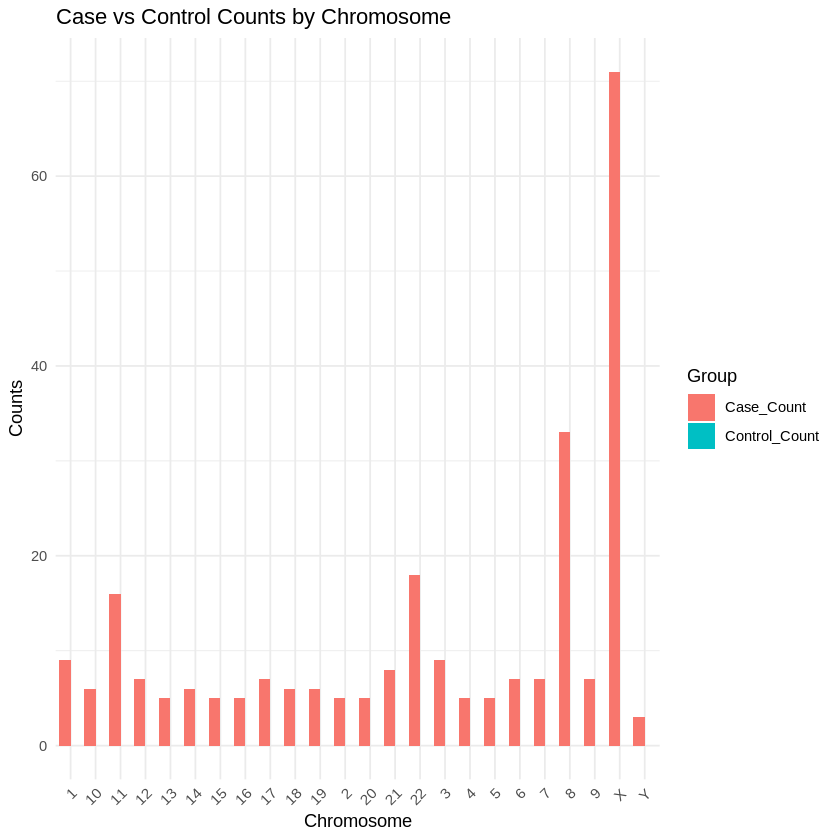

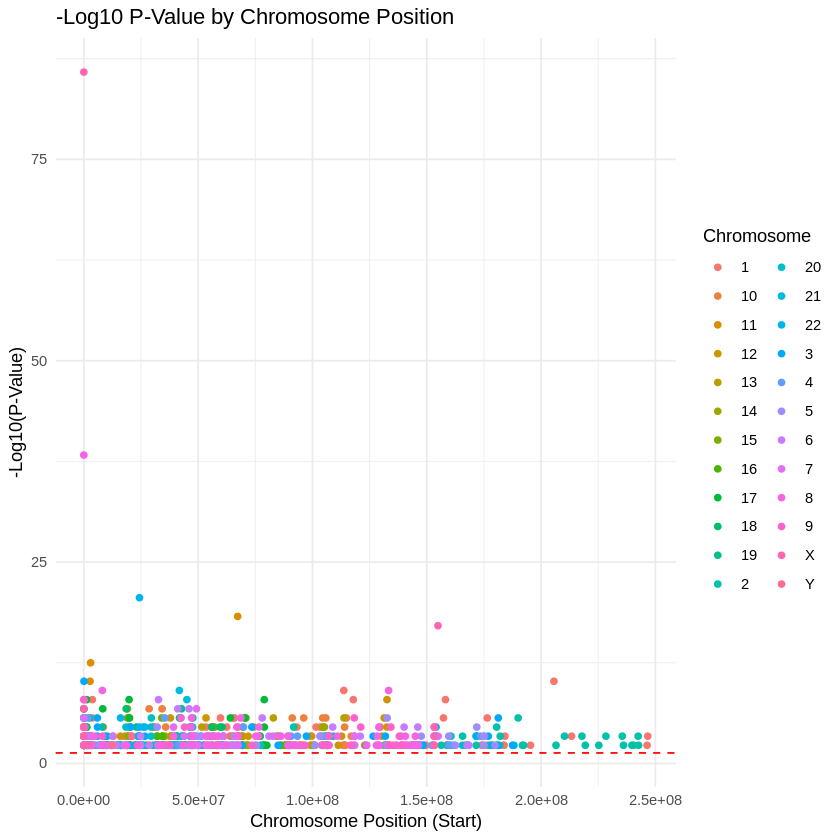

In [3]:
# Load required libraries
library(dplyr)
library(readr)
library(tidyr)
library(ggplot2)

# Load the data
case_data <- read_csv('PC_case.csv')
control_data <- read_csv('PC_control.csv')
gene_list <- read_csv('geneList.csv')

# Rename columns for clarity
colnames(case_data) <- c('Chromosome', 'Start', 'End', 'Type', 'Patient_ID')
colnames(control_data) <- c('Chromosome', 'Start', 'End', 'Type', 'Patient_ID')
colnames(gene_list) <- c('Gene_ID', 'Unused', 'Chromosome', 'Gene_Start', 'Gene_End')

# Drop unused column in gene_list
gene_list <- gene_list %>% select(-Unused)

# Group case and control data by chromosomal regions
case_regions <- case_data %>%
  group_by(Chromosome, Start, End, Type) %>%
  summarise(Case_Count = n(), .groups = 'drop')

control_regions <- control_data %>%
  group_by(Chromosome, Start, End, Type) %>%
  summarise(Control_Count = n(), .groups = 'drop')

# Merge case and control regions
merged_regions <- full_join(case_regions, control_regions,
                            by = c('Chromosome', 'Start', 'End', 'Type')) %>%
  replace_na(list(Case_Count = 0, Control_Count = 0))

# Calculate total case and control patient counts
total_case_patients <- n_distinct(case_data$Patient_ID)
total_control_patients <- n_distinct(control_data$Patient_ID)

# Perform Fisher's exact test
fisher_test <- function(case_count, control_count) {
  case_absence <- total_case_patients - case_count
  control_absence <- total_control_patients - control_count
  contingency_table <- matrix(c(case_count, control_count, case_absence, control_absence),
                              nrow = 2)
  p_val <- fisher.test(contingency_table, alternative = 'greater')$p.value
  return(p_val)
}

merged_regions <- merged_regions %>%
  rowwise() %>%
  mutate(P_Value = fisher_test(Case_Count, Control_Count))

# Filter significant regions (p-value < 0.05)
significant_regions <- merged_regions %>%
  filter(P_Value < 0.05)

# Map significant regions to genes
map_to_genes <- function(region_chrom, region_start, region_end, genes) {
  overlapping_genes <- genes %>%
    filter(Chromosome == paste0('chr', region_chrom),
           Gene_End >= region_start,
           Gene_Start <= region_end)
  paste(overlapping_genes$Gene_ID, collapse = ';')
}

significant_regions <- significant_regions %>%
  rowwise() %>%
  mutate(Associated_Genes = map_to_genes(Chromosome, Start, End, gene_list))

# Save results to a CSV file
write_csv(significant_regions, 'Significant_Regions_with_Genes.csv')

# Bar Plot: Case vs Control Counts
bar_data <- significant_regions %>%
  select(Chromosome, Case_Count, Control_Count) %>%
  pivot_longer(cols = c(Case_Count, Control_Count),
               names_to = "Group",
               values_to = "Counts")

ggplot(bar_data, aes(x = Chromosome, y = Counts, fill = Group)) +
  geom_bar(stat = 'identity', position = 'dodge') +
  theme_minimal() +
  labs(title = 'Case vs Control Counts by Chromosome',
       x = 'Chromosome',
       y = 'Counts',
       fill = 'Group') +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Scatter Plot: Chromosome Position vs P-Value
significant_regions <- significant_regions %>%
  mutate(log_P_Value = -log10(P_Value))

ggplot(significant_regions, aes(x = Start, y = log_P_Value, color = Chromosome)) +
  geom_point() +
  geom_hline(yintercept = -log10(0.05), color = 'red', linetype = 'dashed') +
  theme_minimal() +
  labs(title = '-Log10 P-Value by Chromosome Position',
       x = 'Chromosome Position (Start)',
       y = '-Log10(P-Value)',
       color = 'Chromosome')